# Machine Learning in Python - Project 1

Due Friday, April 9th by 5 pm UK local time.

*include contributors names here*

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
# Add any additional libraries or submodules below

# Display plots inline
# %matplotlib inline
import matplotlib.pyplot as plt

# sklearn
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.compose import ColumnTransformer


# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns

# tools
import sys
sys.path.append(r'Code')
from predata import tools

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80


## 1. Introduction

These data come from the booking systems of two real hotels and reflect bookings made between July 1st, 2015 through August 31st 2017.

If customers booked the orders, the hotel need to reserve the rooms and guarantee that these room is not occupied in the booked day for them and before arriving, the customers are allowed to cancel the orders. The hotels will suffer from the potential loss when an order canceled. Study on the reason why customers cancel their reservation should be drived from the hotel itself and the different information of the customers.

- The hotel suffer losses if there are some reservation canceled.
- The customers choose to cancel the books which is motivated by certain reasons reflected in the data.

This is a classification problem, and our goal is to predict the probablity of a canceled reservation through the features of the customer. For the original data, there are 29 chararteristics for each customer. To solve this question, we can choose several methods, including logistic regression, support vector machine(SVM), naive bayes, decision tree and random forest method. In our study, we have tried logistic regression, svm, random forest(which always has better performance than decision tree).

In [3]:
# Load data
df = pd.read_csv(r'D:\Edinburgh-Learn\MLIP\mlp-proj2-mlp-proj2\Code\Data\hotel.csv')
df.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


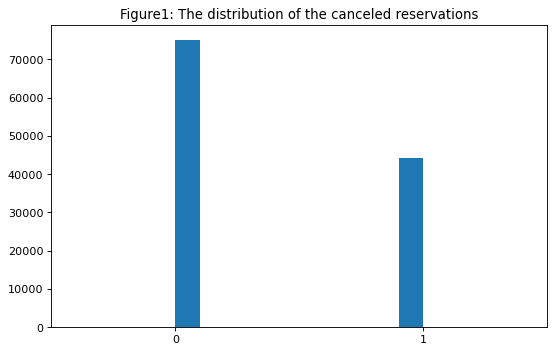

In [4]:
# Figure 1: Distribution of canceled reservations
fignum = 1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Figure%d: The distribution of the canceled reservations' % fignum)

ax.hist(df['is_canceled'], rwidth=4)
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5)
plt.show()

In [5]:
#  The information entropy of the outcome of our interest
p = df['is_canceled'].sum()/df.shape[0]
Ent = tools.entropyValue(p)
print('the original information entropy is %0.2f' % Ent)


the original information entropy is 0.95


## 2. Exploratory Data Analysis and Feature Engineering

Before we do some feature engineering, we need to handle those missing values and outliers in our data to make our data more tidy.
- There are 4 features have missing values: `children`, `country`, `agent`, `company`. Among them, `company` missed near 94 percent data, so, we need delete this feature
- The abnormal values occured in the `adr` featuer, and we just drop them. Here, we only delete those `adr`<0.

In [6]:
# Handel missing value
# ----Find the missing values----
missing = df.isna().apply(np.sum, axis=0)
# {children:4/0.000034, country:488/0.004087, agent:16340/0.136862, company:112593/0.943069}
pd.DataFrame(missing[missing != 0]/119390, columns=['missing'])

,missing
children,0.000034
country,0.004087
agent,0.136862
company,0.943069


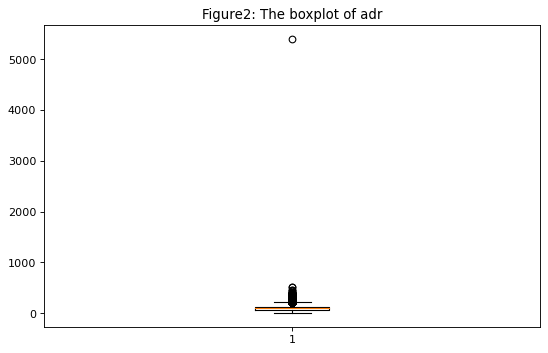

In [7]:
# impute missing values and abnormal values
# [1]. Children: only 4 missing value (nearly no effect on result after impute them by using mode)
df['children'] = df['children'].fillna(0)
# [2]. agent: we regard the missing value as one of the attributes and take it into account.nHere, we just replace them of 0
df['agent'] = df['agent'].replace(np.nan, 0)
#[3]. country: replaced by PRT
df['country'] = df['country'].fillna('PRT')
# Abnormal values
fignum+=1
fig = plt.figure()
plt.title('Figure%d: The boxplot of adr'%fignum)
plt.boxplot(df['adr'])
plt.show()
df = df.drop(df[df['adr'] < 0].index, axis=0).drop(df[df['adr']==df['adr'].max()].index,axis=0)

There are too many features in our data, and we need to do some feature extraction and engineering to make it easy to model. We analyze the features through two perspectives. On the one hand, we should explore the feature itself, including its attributes, variance, missing value and so on. For instance, if one feature has too many same attributes or missing value, we are supposed to delete this feature because it can't contibute a lot to the outcome. On the other hand, we are also expected to analyze the relationship between the outcome and features. Here, we refer to the idea of the dicision trees. We can divided our feature space by one, and compare the difference before and after division. To evaluate this quantitively, we can compute the gini value and we can plot it with the probability of canceled reservations.

- Drop the `company`: `Company` has too much missing values, over 90%, and so, we drop this feature directly.
- Drop the `arrival_date_year`: There are three years data, but if we plot it with the probability of the canceled reservations, we will find it has no relationship with the outcome of interest
- Drop the `arrival_date_month`: This feature is dominated by the `arrival_date_week_number`, and the skitlearn prefer the numeric features.
- Transform the `reserved_room_type` and `assigned_room_type`: Assign a new feature and it is 1 if the reserved and assigned are same ortherwise it is 0
- Keep all the numeric features: Tree-based method require use use the float features.

***hotel***: 

These two hotels have obvious difference in probability of cancels. Because we finally use random forest model, we needn't use dummies and here, we just to label them using number. This can be achieved by `LabelEncoder()` function in sklearn.

***Time***: 

There are 7 time related features and finally we only delete year and month because we believe there may be periodic charateristics for the probability of cancels and this is similar in each year except in certain specail year. As for month, this is dominated by the feature `arrival_date_week_number`.

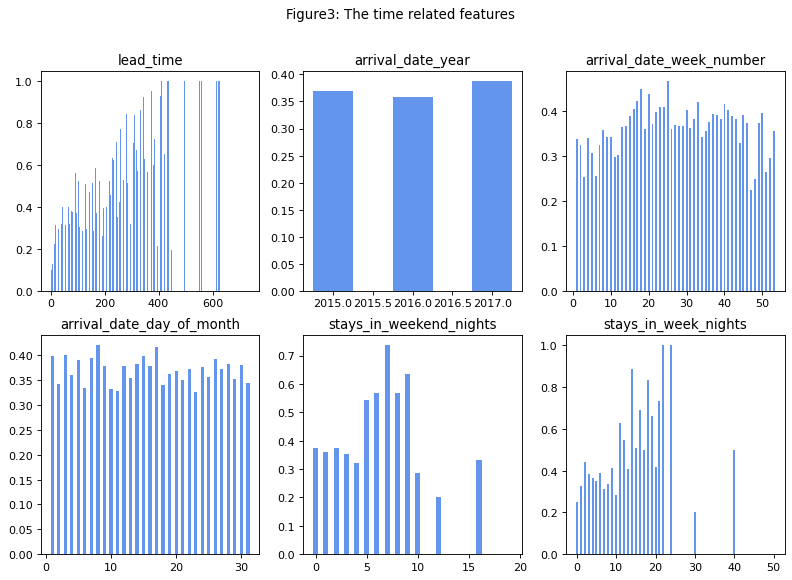

In [8]:
# Time
fignum += 1
fig_time = plt.figure(figsize=(12, 8))
plt.suptitle("Figure%d: The time related features" % fignum)

time_list=['lead_time','arrival_date_year','arrival_date_week_number',
'arrival_date_day_of_month','stays_in_weekend_nights','stays_in_week_nights']
i = 1
prob={}
for t in time_list:
    ax = fig_time.add_subplot(2,3,i)
    prob[t]=tools.association_analysis(t,True,df,ax)
    ax.set_title(t)
    i+=1

plt.show()


***people***: 

- Delete the `children` and `babies` these two features because their properties. Over 90% customers booked the orders without children or babies, and so, there two features can't provide enough information for our study.

In [9]:
# People
freq_children = tools.property_analysis('children',df)
freq_babies = tools.property_analysis('babies',df)
people_report = {'children':{'0/%':freq_children.max()},'babies':{'0/%':freq_babies.max()}}
pd.DataFrame(people_report)

,children,babies
0/%,0.92805,0.992319


***Categorical***:

- Delete the `agent` and `country` for the hope that our model become more general. These two features devide our feature space too small, leading to the overfit problems.
- Delete the `meal` and `is_repeated_gueat` because their Gini values are so small that means these features can't make some contributions to the prediction of the canceled reservations.
- Add a new feature `same_room`. This feature equal to 0 if the booked room and the assigned room are same, otherwise is 1. The delete the `reserved_room_type` and `assigned_room_type`.
- As for the Other categorical features, we use labels to encode them.

In [10]:
# catigorical features
cat=['meal','market_segment','distribution_channel','deposit_type','customer_type','is_repeated_guest']
IG = {}  # information gain
for c in cat:
    prob_cat = tools.association_analysis(c,False,df,None)
    Ent_cat = tools.cal_Ent(prob_cat)
    feq_cat = tools.property_analysis(c,df)
    gain_cat = tools.cal_Gain(Ent,Ent_cat,list(feq_cat))
    IG[c]=round(gain_cat,3)
pd.Series(IG).sort_values(ascending=False)

market_segment          0.246
distribution_channel    0.204
deposit_type            0.189
customer_type           0.145
is_repeated_guest       0.002
meal                    0.001
dtype: float64

In [11]:
# Add new column
res_room, ass_room = df.loc[:,'reserved_room_type'], df.loc[:, 'assigned_room_type']
same_room = []
for i, j in zip(res_room, ass_room):
    if i == j:
        same_room.append(1)
    else:
        same_room.append(0)
df['same_room'] = same_room


***numeric(part)***

For these features, we can observe that there are some segmented characteristics which can be recognised by the tree-based models. However, finally, we just remain the `adr`
- Only passthrough the `adr` and `booking_changes`, because for the other features, over 95% offered the same information. For example, 97% customers have 0 previous not canceled bookings.

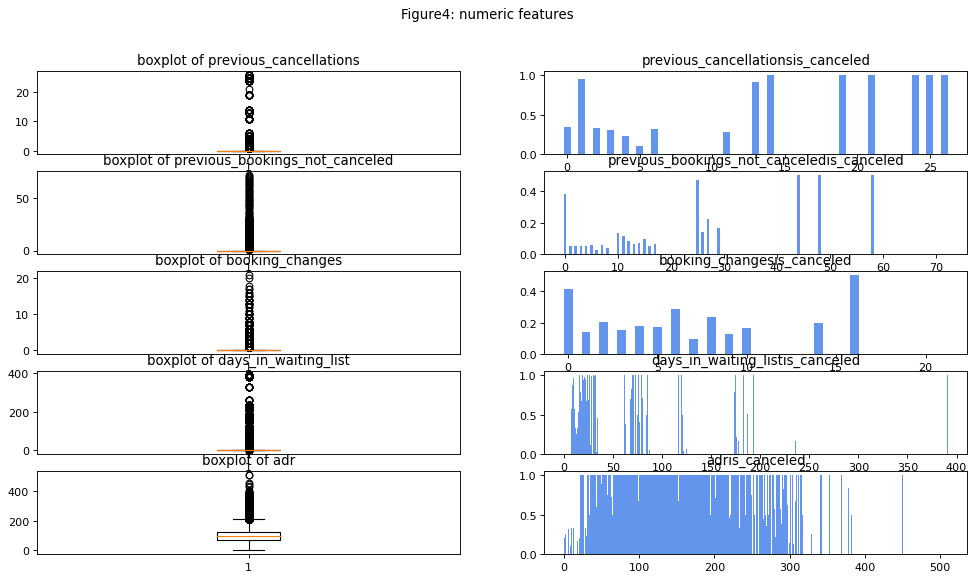

In [12]:
# Part of the numeric features
numeric = ['previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list','adr']
fig_num = plt.figure(figsize=(15,8))
fignum+=1
plt.suptitle('Figure%d: numeric features'%fignum)
i = 1
freq_num = {}
for n in numeric:
    data_num = df[n]
    
    # boxplot
    ax = fig_num.add_subplot(5,2,i)
    ax.boxplot(data_num)
    ax.set_title('boxplot of '+n)
    i+=1
    # Associarion plot
    ax2 = fig_num.add_subplot(5, 2, i)
    prob_n = tools.association_analysis(n,True,df,ax2)
    ax2.set_title(n+'is_canceled')
    i+=1

    # propertis:
    freq_n = tools.property_analysis(n,df)
    freq_num[n] = freq_n.max()

plt.show()

In [13]:
pd.Series(freq_num).round(3)

previous_cancellations            0.946
previous_bookings_not_canceled    0.970
booking_changes                   0.849
days_in_waiting_list              0.969
adr                               0.031
dtype: float64

***Requirment***
- Delete the `required_car_parking_spaces` for the same reason as `previous_cancelations`.
- passthrough the `total_of_special_requests`, and we can find that the more number of `total_of_special_requests`, the smaller probability to cancel the bookings.

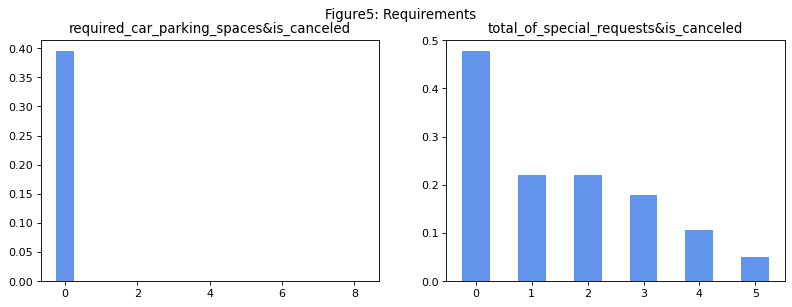

{'required_car_parking_spaces': 0.9378832043421449,
 'total_of_special_requests': 0.5889704157871813}

In [14]:
# Requirement
req = ['required_car_parking_spaces', 'total_of_special_requests']
freq_req={}
fig_req = plt.figure(figsize=(12,4))
fignum+=1
plt.suptitle('Figure%d: Requirements'%fignum)
i=1
for r in req:
    freq_r = tools.property_analysis(r,df)
    freq_req[r] = freq_r.max()

    ax = fig_req.add_subplot(1,2,i)
    prob_r = tools.association_analysis(r,True,df,ax)
    ax.set_title(r+'&'+'is_canceled')
    i+=1
plt.show()
freq_req

**In conclusion, we should do following operations on our original data:**
- Passthrough 14 features: `hotel`, `lead_time`, `week_number`, `day_of_month`,`stays_in_weekend_nights`, `stays_in_week_nights`, `adults`, `market_segment`, `distribution_channel`,`booking_changes`, `deposit_type`, `customer_type`,`adr`, `total_of_special_requests`.

- LabelEncoder those catigorical features (if we use logistic model, we should Onehot them)

In [29]:
passthrough = ['is_canceled', 'hotel', 'lead_time',
               'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
               'stays_in_week_nights', 'adults', 'market_segment', 'distribution_channel', 'same_room',
               'booking_changes', 'deposit_type', 'customer_type', 'total_of_special_requests']
ct = ColumnTransformer(
    [
        ('keep', 'passthrough',passthrough)
    ]
)

ct.fit(df)
names = ct.get_feature_names()
dataset = pd.DataFrame(ct.transform(df), columns=names)
cat = ['hotel','market_segment','distribution_channel','deposit_type','customer_type']
for c in cat:
    dataset[c] = LabelEncoder().fit_transform(dataset[c])
dataset.head()


,is_canceled,hotel,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,market_segment,distribution_channel,same_room,booking_changes,deposit_type,customer_type,total_of_special_requests
0,0,1,342,27,1,0,0,2,3,1,1,3,0,2,0
1,0,1,737,27,1,0,0,2,3,1,1,4,0,2,0
2,0,1,7,27,1,0,1,1,3,1,0,0,0,2,0
3,0,1,13,27,1,0,1,1,2,0,1,0,0,2,0
4,0,1,14,27,1,0,2,2,6,3,1,0,0,2,1


In [30]:
ct_onehot = ColumnTransformer(
    [
        ('keep', 'passthrough', passthrough), 
        ('onthot', OneHotEncoder(), cat)
    ]
)
ct_onehot.fit(df)
names_onehot = ct_onehot.get_feature_names()
dataset_onehot = pd.DataFrame(ct_onehot.transform(df), columns=names_onehot).copy()
dataset_onehot=dataset_onehot.drop(cat,axis=1)
dataset_onehot.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,same_room,booking_changes,total_of_special_requests,...,onthot__x2_GDS,onthot__x2_TA/TO,onthot__x2_Undefined,onthot__x3_No Deposit,onthot__x3_Non Refund,onthot__x3_Refundable,onthot__x4_Contract,onthot__x4_Group,onthot__x4_Transient,onthot__x4_Transient-Party
0,0,342,27,1,0,0,2,1,3,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,737,27,1,0,0,2,1,4,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,7,27,1,0,1,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,13,27,1,0,1,1,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,14,27,1,0,2,2,1,0,1,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of the client who is with the hotel data and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [17]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf proj2.ipynb

'jupyter' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
